In [70]:
rm(list=ls())
library(ggplot2)
library(sva)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("pheatmap")



## Load the data

In [71]:
#load ATAC-seq raw read counts
data=read.table('atac.counts.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL



In [72]:
#load the metadata
batches=read.table("../atacseq_batches_truerep.txt",header=TRUE,sep='\t',row.names=1,stringsAsFactors = FALSE)


In [73]:
earlyG1=data[,1:4]
earlyG1_batches=batches[1:4,]

lateG1=data[,5:8]
lateG1_batches=batches[5:8,]

SG2M=data[,9:12]
SG2M_batches=batches[9:12,]


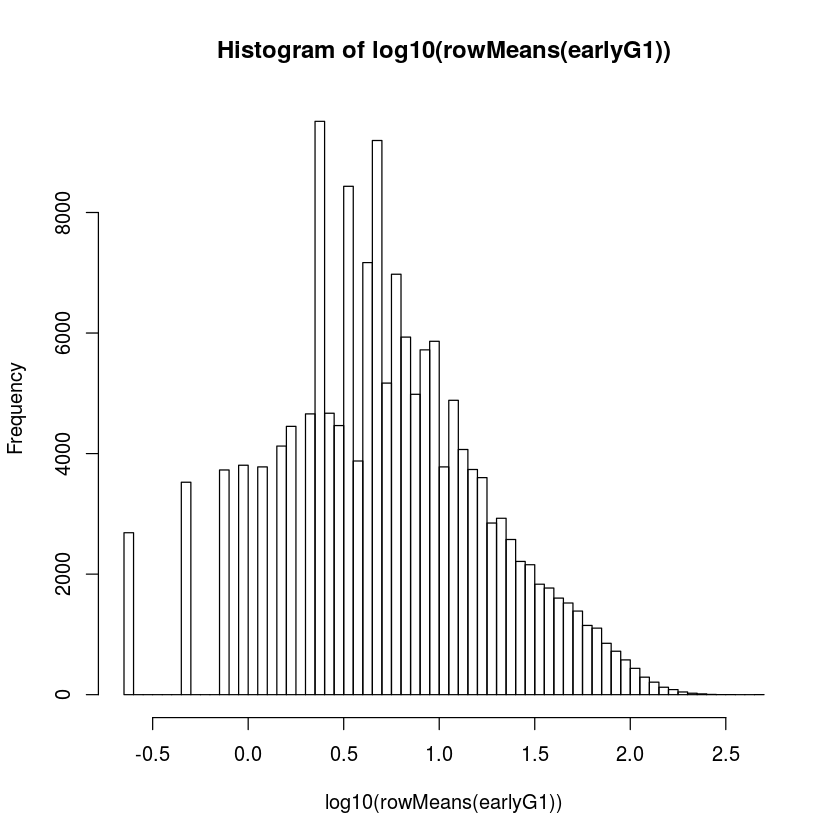

In [74]:
hist(log10(rowMeans(earlyG1)),breaks=100)

In [102]:
log10(0.5)

[1] -0.30103

In [76]:
earlyG1_batches$CellCycle=factor(earlyG1_batches$CellCycle)
earlyG1_batches$Treatment=factor(earlyG1_batches$Treatment)
earlyG1_batches$Sample=factor(earlyG1_batches$Sample)

In [77]:
lateG1_batches$CellCycle=factor(lateG1_batches$CellCycle)
lateG1_batches$Treatment=factor(lateG1_batches$Treatment)
lateG1_batches$Sample=factor(lateG1_batches$Sample)

In [78]:
SG2M_batches$CellCycle=factor(SG2M_batches$CellCycle)
SG2M_batches$Treatment=factor(SG2M_batches$Treatment)
SG2M_batches$Sample=factor(SG2M_batches$Sample)

In [79]:
#Create DESeq objects
earlyG1_dds <- DESeqDataSetFromMatrix(countData = earlyG1,
                              colData = earlyG1_batches,
                              design = ~Treatment)

In [80]:
lateG1_dds <- DESeqDataSetFromMatrix(countData = lateG1,
                              colData = lateG1_batches,
                              design = ~Treatment)

In [81]:
SG2M_dds <- DESeqDataSetFromMatrix(countData = SG2M,
                              colData = SG2M_batches,
                              design = ~Treatment)

## Size Factor Estimates 

In [82]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_promoters=read.table("HK.promoters.txt",header=TRUE,sep='\t')
hk_promoters=paste(hk_promoters$Chrom,hk_promoters$Start,hk_promoters$End,sep="_")
hk_promoter_indices=match(hk_promoters,rownames(data))

earlyG1_dds <- estimateSizeFactors(earlyG1_dds, controlGenes=hk_promoter_indices)
lateG1_dds <- estimateSizeFactors(lateG1_dds, controlGenes=hk_promoter_indices)
SG2M_dds <- estimateSizeFactors(SG2M_dds, controlGenes=hk_promoter_indices)


In [83]:
earlyG1_dds$sizeFactor

earlyG1_controls_Rep1 earlyG1_controls_Rep2     earlyG1_DMSO_Rep1 
            1.0210431             0.9529249             0.9765251 
    earlyG1_DMSO_Rep2 
            1.0863119

## Visualizations 

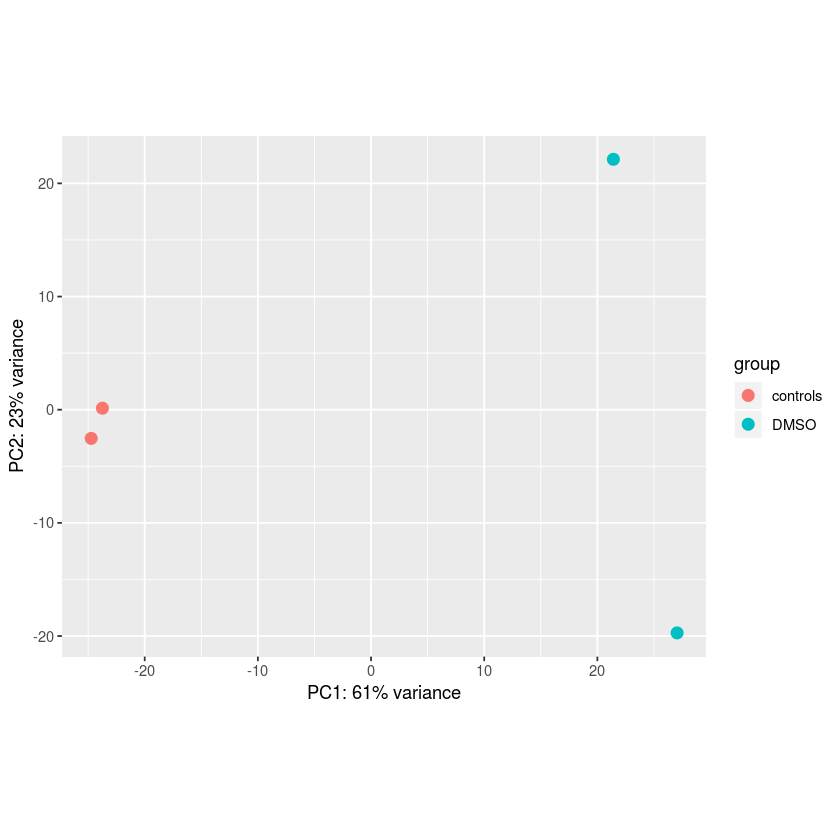

In [84]:
source('plotPCA_custom.R')
earlyG1_se <- SummarizedExperiment(log2(counts(earlyG1_dds, normalized=TRUE) + 1),
                           colData=colData(earlyG1_dds))
plotPCA_custom( DESeqTransform( earlyG1_se ),intgroup=c("Treatment"),pcx=1,pcy=2)


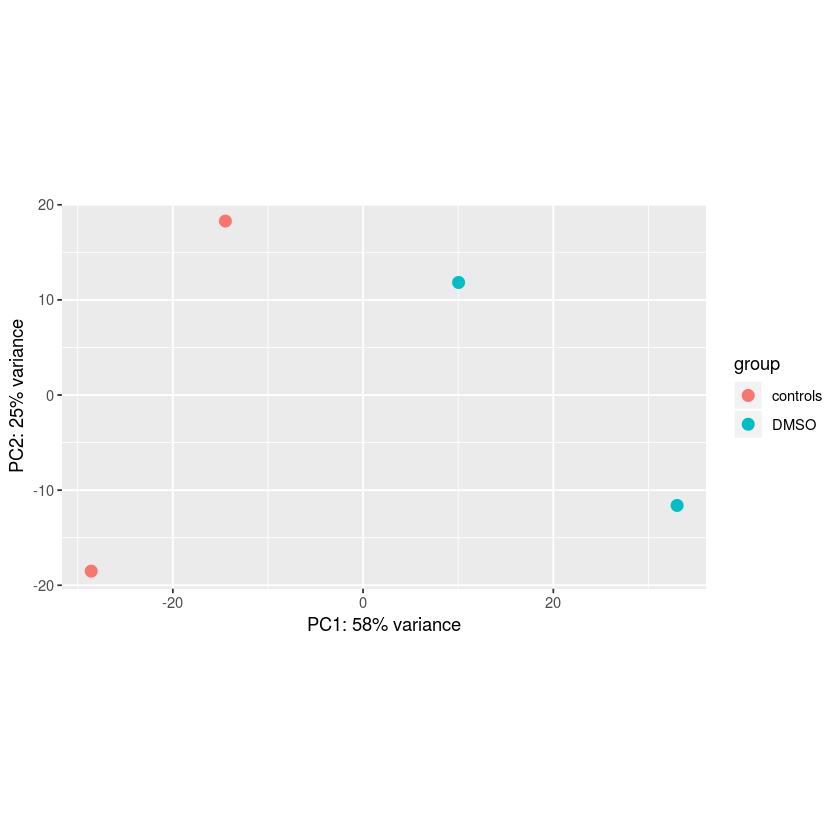

In [85]:
lateG1_se <- SummarizedExperiment(log2(counts(lateG1_dds, normalized=TRUE) + 1),
                           colData=colData(lateG1_dds))
plotPCA_custom( DESeqTransform( lateG1_se ),intgroup=c("Treatment"),pcx=1,pcy=2)


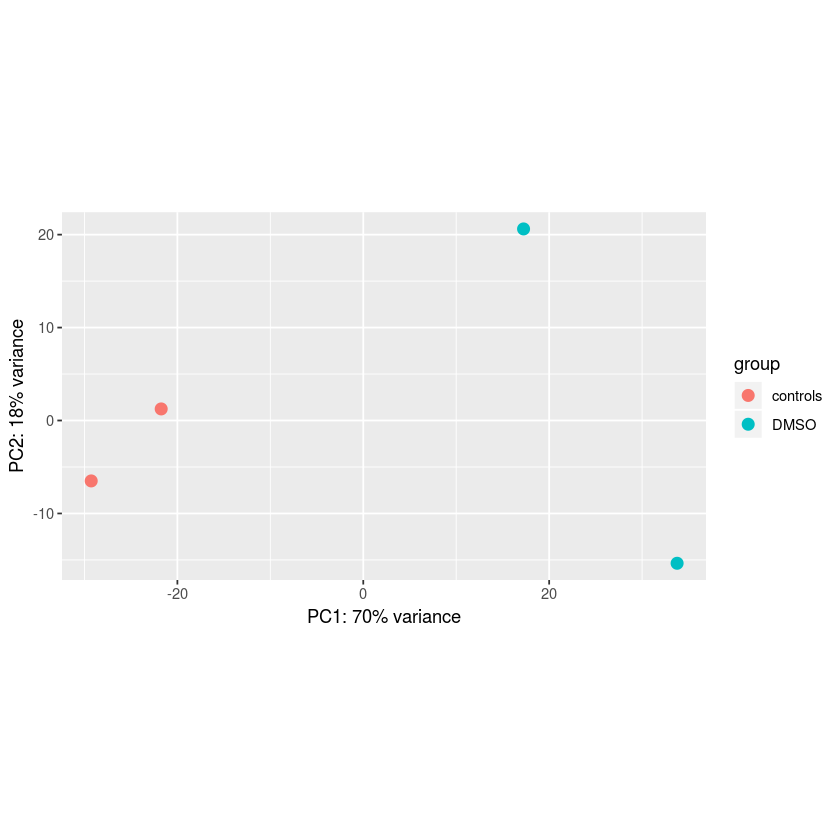

In [86]:
SG2M_se <- SummarizedExperiment(log2(counts(SG2M_dds, normalized=TRUE) + 1),
                           colData=colData(SG2M_dds))
plotPCA_custom( DESeqTransform( SG2M_se ),intgroup=c("Treatment"),pcx=1,pcy=2)


In [87]:
earlyG1_vsd=vst(earlyG1_dds,blind=FALSE)
lateG1_vsd=vst(lateG1_dds,blind=FALSE)
SG2M_vsd=vst(SG2M_dds,blind=FALSE)


-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.


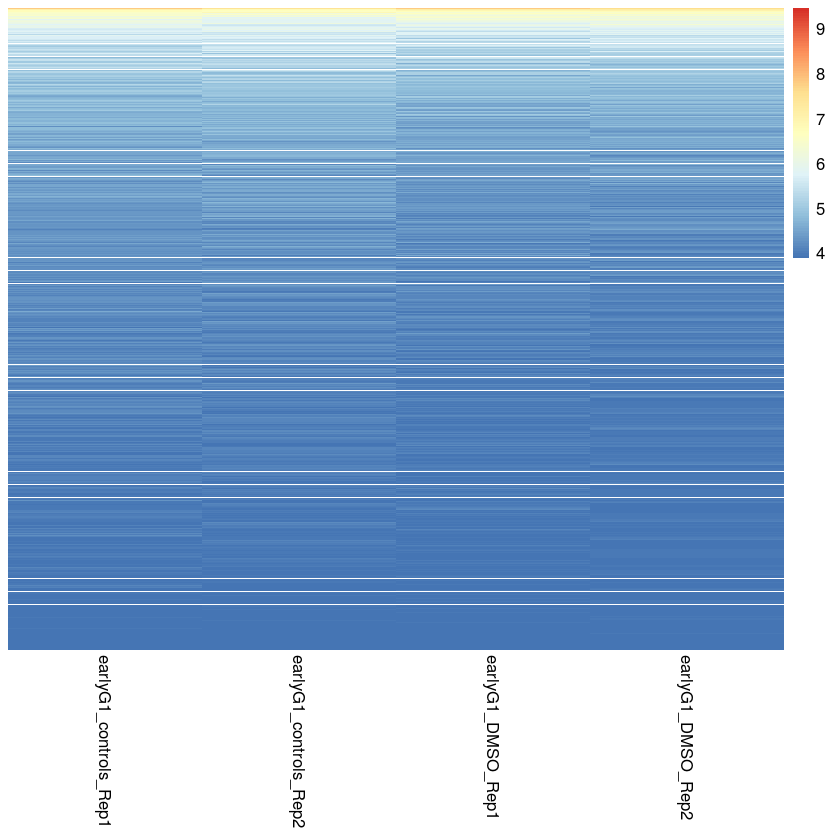

In [88]:
earlyG1_select <- order(rowMeans(counts(earlyG1_dds,normalized=TRUE)),
                decreasing=TRUE)
earlyG1_df <- as.data.frame(colData(earlyG1_dds)[,c("Treatment")])

pheatmap(assay(earlyG1_vsd)[earlyG1_select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE)


In [89]:
?pheatmap

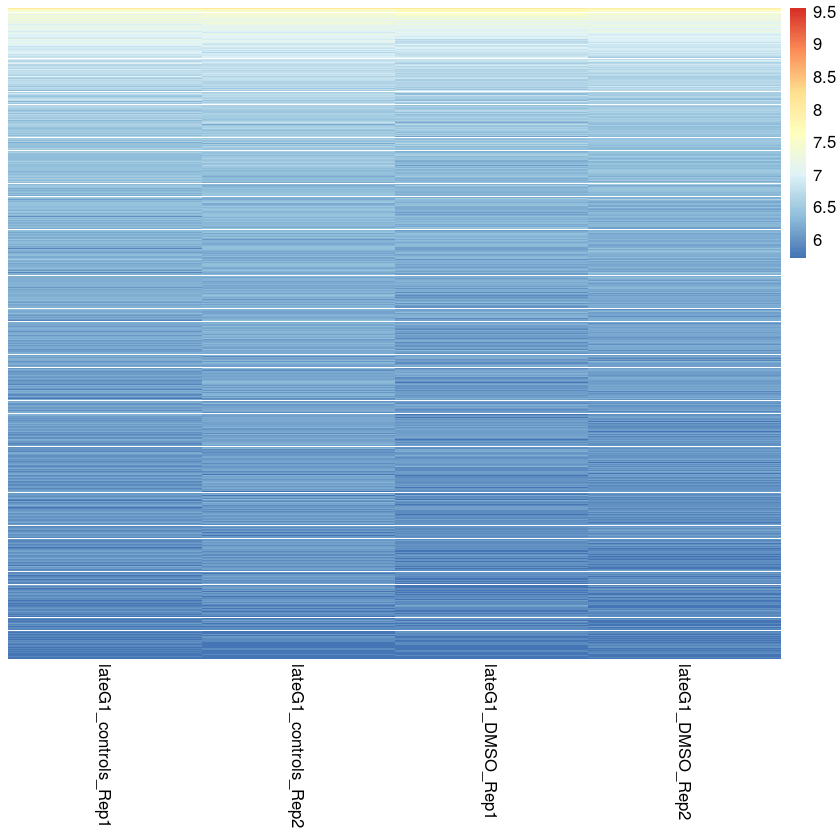

In [90]:
lateG1_select <- order(rowMeans(counts(lateG1_dds,normalized=TRUE)),
                decreasing=TRUE)
lateG1_df <- as.data.frame(colData(lateG1_dds)[,c("Treatment")])
pheatmap(assay(lateG1_vsd)[lateG1_select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE)


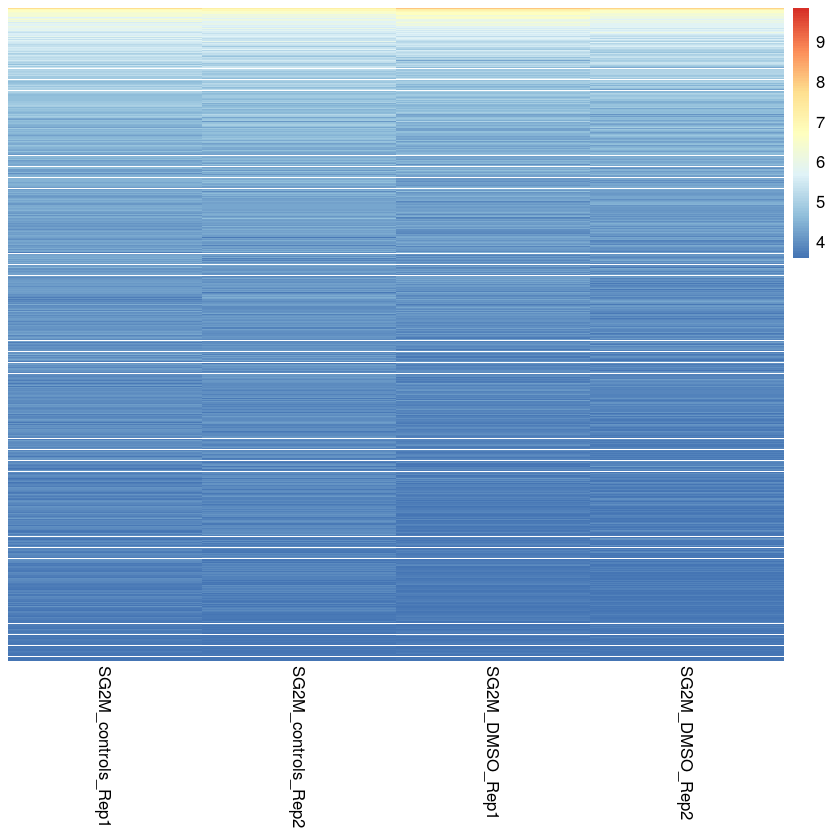

In [91]:
SG2M_select <- order(rowMeans(counts(SG2M_dds,normalized=TRUE)),
                decreasing=TRUE)
SG2M_df <- as.data.frame(colData(SG2M_dds)[,c("Treatment")])
pheatmap(assay(SG2M_vsd)[SG2M_select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE)

## Differential Accessibility Operation

In [92]:
earlyG1_dds <- DESeq(earlyG1_dds,parallel = TRUE)
lateG1_dds <- DESeq(lateG1_dds,parallel = TRUE)
SG2M_dds <- DESeq(SG2M_dds,parallel = TRUE)



using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates, fitting model and testing: 20 workers
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates, fitting model and testing: 20 workers
using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
-- note: 

In [93]:
res_earlyG1=results(earlyG1_dds,name="Treatment_DMSO_vs_controls",parallel=TRUE)
res_lateG1=results(lateG1_dds,name="Treatment_DMSO_vs_controls",parallel=TRUE)
res_SG2M=results(SG2M_dds,name="Treatment_DMSO_vs_controls",parallel=TRUE)


In [94]:
summary(res_earlyG1)


out of 159263 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 2, 0.0013%
LFC < 0 (down)     : 19, 0.012%
outliers [1]       : 0, 0%
low counts [2]     : 135796, 85%
(mean count < 20)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [95]:
summary(res_lateG1)


out of 160326 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1, 0.00062%
LFC < 0 (down)     : 3, 0.0019%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [96]:
summary(res_SG2M)


out of 160187 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 9, 0.0056%
LFC < 0 (down)     : 11, 0.0069%
outliers [1]       : 0, 0%
low counts [2]     : 124206, 78%
(mean count < 13)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



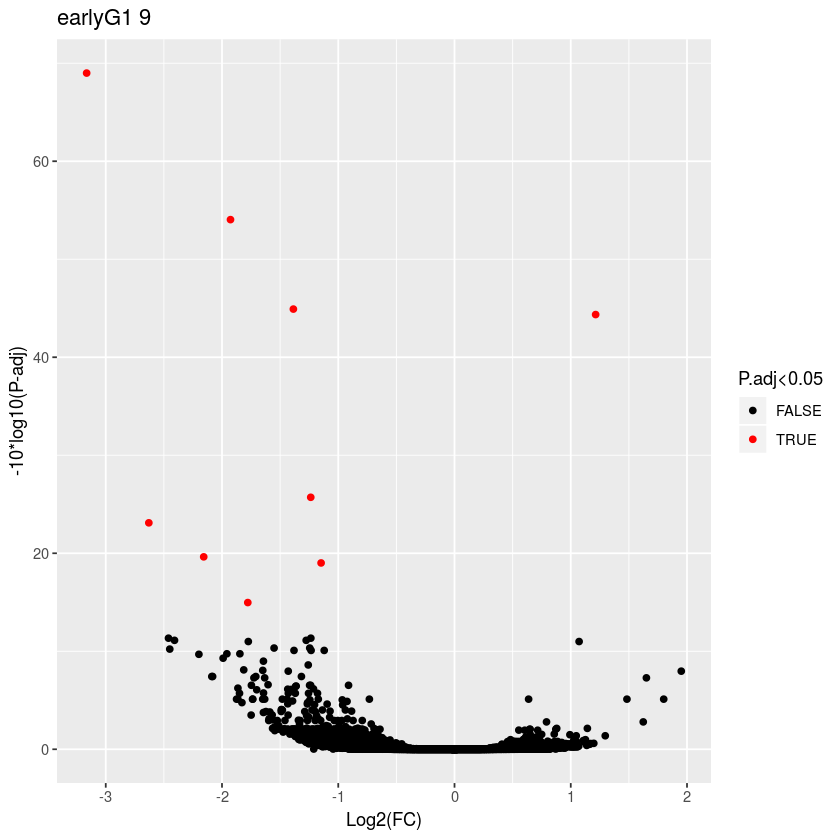

In [97]:
 res_earlyG1$logPadj=-10*log10(res_earlyG1$padj)
 res_earlyG1=na.omit(as.data.frame(res_earlyG1))
 numsig=sum(res_earlyG1$padj <= 0.05)
 sigsubset_earlyG1=res_earlyG1[res_earlyG1$padj<=0.05,]
 outlabel=paste("earlyG1",numsig)
 res_earlyG1$color=res_earlyG1$padj<=0.05
 print(ggplot(data=res_earlyG1,
        aes(x=res_earlyG1$log2FoldChange,
            y=res_earlyG1$logPadj,
            color=res_earlyG1$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))

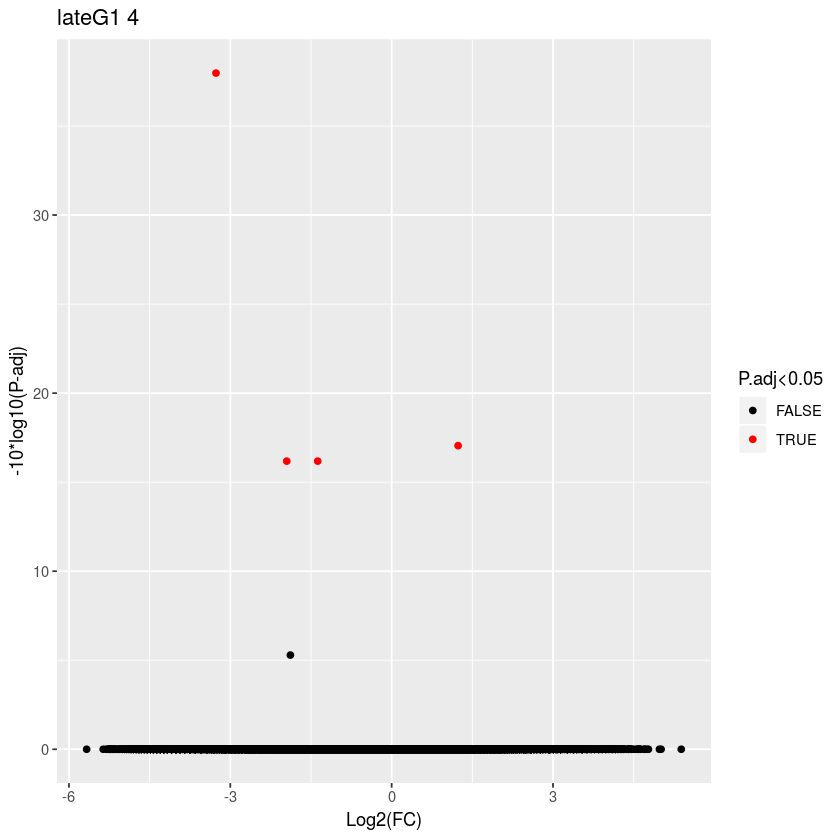

In [98]:
 res_lateG1$logPadj=-10*log10(res_lateG1$padj)
 res_lateG1=na.omit(as.data.frame(res_lateG1))
 numsig=sum(res_lateG1$padj <= 0.05)
 sigsubset_lateG1=res_lateG1[res_lateG1$padj<=0.05,]
 outlabel=paste("lateG1",numsig)
 res_lateG1$color=res_lateG1$padj<=0.05
 print(ggplot(data=res_lateG1,
        aes(x=res_lateG1$log2FoldChange,
            y=res_lateG1$logPadj,
            color=res_lateG1$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))

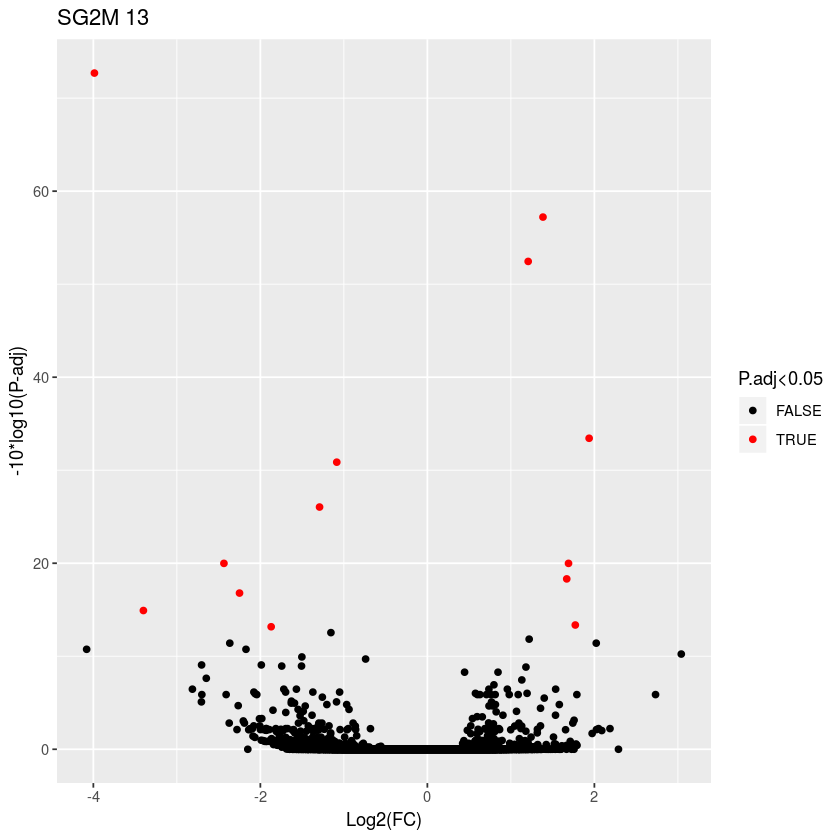

In [99]:
 res_SG2M$logPadj=-10*log10(res_SG2M$padj)
 res_SG2M=na.omit(as.data.frame(res_SG2M))
 numsig=sum(res_SG2M$padj <= 0.05)
 sigsubset_SG2M=res_SG2M[res_SG2M$padj<=0.05,]
 outlabel=paste("SG2M",numsig)
 res_SG2M$color=res_SG2M$padj<=0.05
 print(ggplot(data=res_SG2M,
        aes(x=res_SG2M$log2FoldChange,
            y=res_SG2M$logPadj,
            color=res_SG2M$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))

In [100]:
earlyG1_dds


class: DESeqDataSet 
dim: 160698 4 
metadata(400): version version ... version version
assays(4): counts mu H cooks
rownames(160698): chr1_10386_10664 chr1_713724_714583 ...
  chrY_22155240_22155436 chrY_59001318_59001596
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(4): earlyG1_controls_Rep1 earlyG1_controls_Rep2
  earlyG1_DMSO_Rep1 earlyG1_DMSO_Rep2
colData names(4): Sample CellCycle Treatment sizeFactor

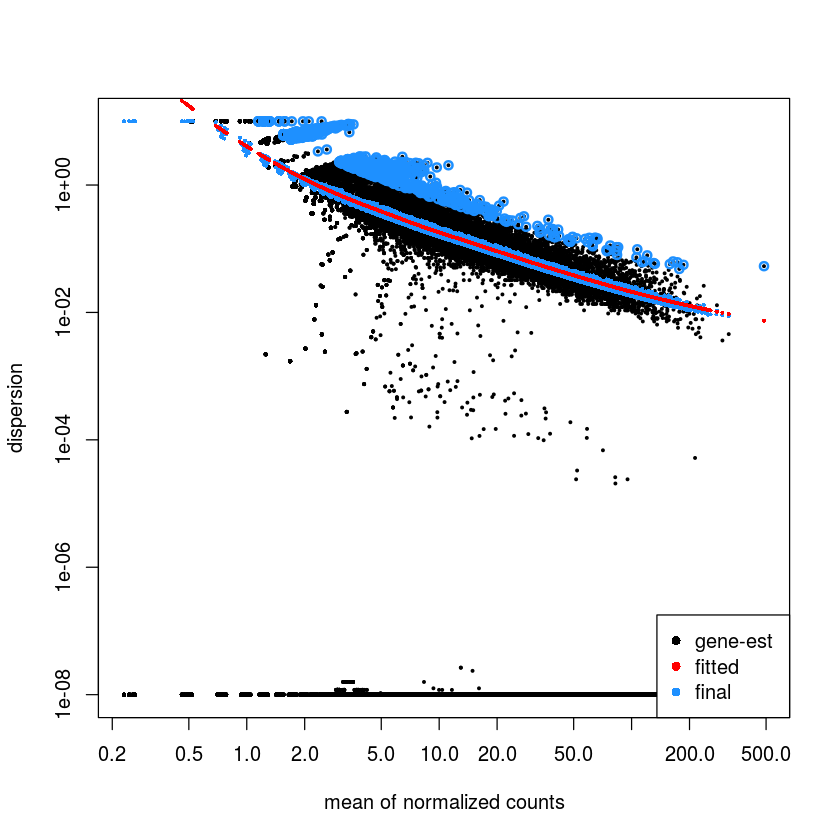

In [104]:
plotDispEsts(earlyG1_dds)


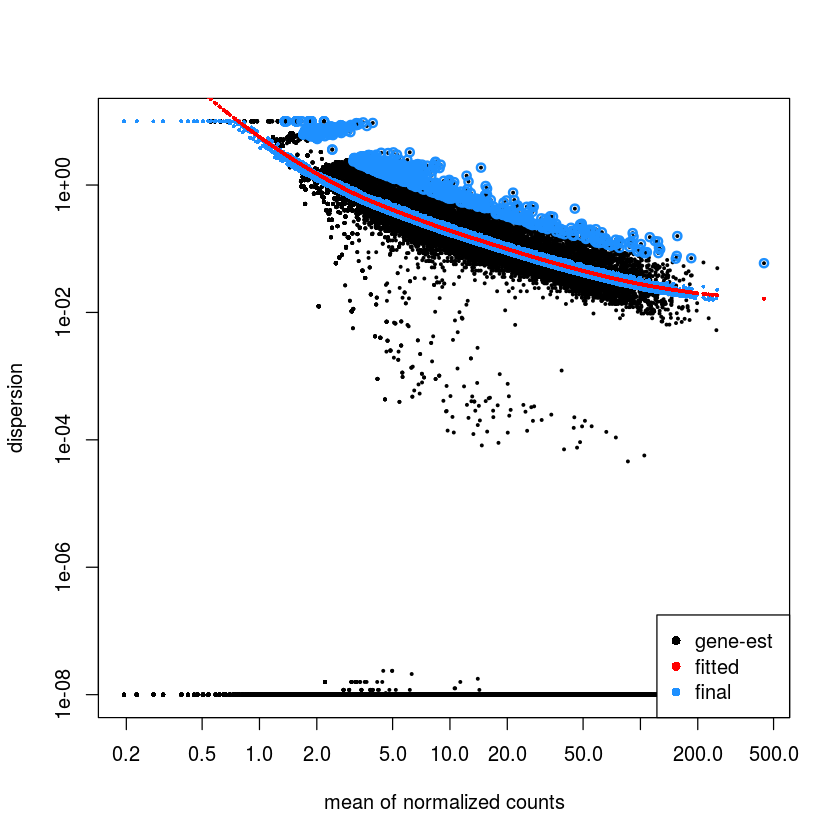

In [105]:
plotDispEsts(lateG1_dds)


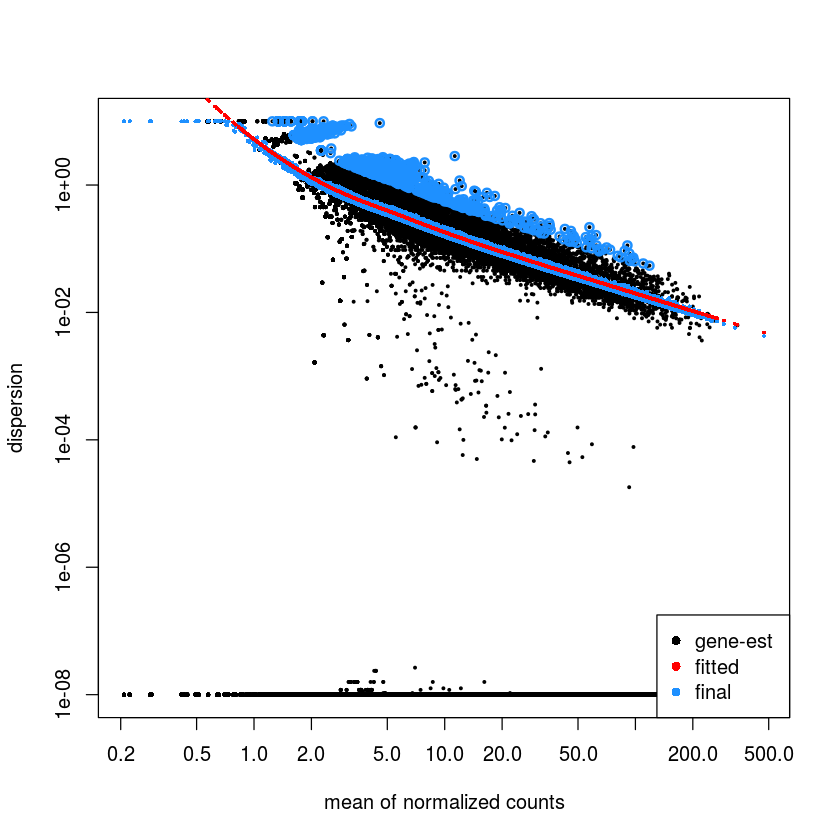

In [106]:
plotDispEsts(SG2M_dds)
